In [1]:
# *** Packages ***
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import floor

Files already downloaded and verified
Files already downloaded and verified


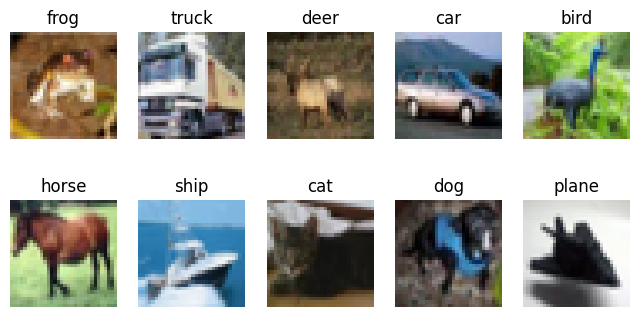

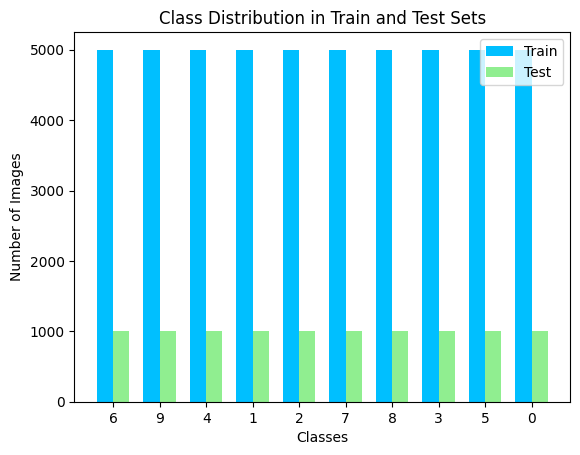


Numero di immagini per classe:
Classe     Training   Test      
------------------------------
plane      5000       1000      
car        5000       1000      
bird       5000       1000      
cat        5000       1000      
deer       5000       1000      
dog        5000       1000      
frog       5000       1000      
horse      5000       1000      
ship       5000       1000      
truck      5000       1000      


In [2]:
'''
Q2
'''
batch_size = 32

transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0,0,0), std=(1,1,1))])

dataset_train= datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer)#transforms.ToTensor())
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test= datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))

classes_map = {
    0 : 'plane',
    1 : 'car',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

figure = plt.figure(figsize=(8, 4))
cols, rows = 5, 2

# Creiamo un dizionario per tenere traccia delle immagini trovate per ogni classe
class_examples = {}

# Cerchiamo un esempio per ogni classe
for i, (img, label) in enumerate(dataset_train):
        # dataset return img, label 
        # enumerate return i
    if label not in class_examples and len(class_examples) < 10:
        class_examples[label] = img
    if len(class_examples) == 10:
        break

# Plottiamo un'immagine per ogni classe
for i, (label, img) in enumerate(class_examples.items(), 1):
    figure.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)
    plt.title(classes_map[label])
    plt.axis("off")
    plt.imshow(img)

plt.show()


# Funzione per estrarre tutte le etichette dal dataloader
def get_labels_from_loader(loader):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())  # Estraiamo le etichette come array numpy
    return np.array(all_labels)


# Otteniamo le etichette da train e test e put them into an array
train_label = get_labels_from_loader(trainloader)
test_label = get_labels_from_loader(testloader)

# Calcoliamo la distribuzione delle classi
_, train_counts = np.unique(train_label, return_counts=True)
_, test_counts = np.unique(test_label, return_counts=True)

# Creiamo il grafico comparativo
bar_width = 0.35
index = np.arange(len(class_examples))

plt.bar(index, train_counts, bar_width, label='Train', color='deepskyblue')
plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='lightgreen')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train and Test Sets')
plt.xticks(index + bar_width / 2, class_examples)
plt.legend()
plt.show()

# Stampiamo i valori
print("\nNumero di immagini per classe:")
print(f"{'Classe':<10} {'Training':<10} {'Test':<10}")
print("-" * 30)
for i in range(10):
    print(f"{classes_map[i]:<10} {train_counts[i]:<10} {test_counts[i]:<10}")

In [3]:
'''
Q3
'''
trainiter = iter(trainloader)
train_images, _ = next(trainiter)

testiter = iter(testloader)
test_images, _ = next(testiter)


# Prendi la prima immagine del batch
first_image = train_images[0]

print(f"Type of each image: {first_image.type}")

# Stampa la dimensione dell'immagine
print(f"Shape of the image tensor: {first_image.shape}")  # (C, H, W)

# Puoi separare in Channels, Height, Width
channels, height, width = first_image.shape
print(f"Width: {width}, Height: {height}, Channels: {channels}")

Type of each image: <built-in method type of Tensor object at 0x3486290e0>
Shape of the image tensor: torch.Size([3, 32, 32])
Width: 32, Height: 32, Channels: 3


In [4]:
'''
Q4
'''
#normalize = transforms.Normalize((0,0,0),(1,1,1))

#normalized_train = normalize(train_images)

#normalized_test = normalize(test_images)

'\nQ4\n'

In [5]:
'''
Q5
'''
dataset_val, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])

validloader = DataLoader(dataset_val, batch_size=len(dataset_val))
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))

In [16]:
'''
Q6
'''
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out


# You can start by modifyng what we have done in class, or define your model from scratch
class CNNS(nn.Module):
    def __init__(self):
        super(CNNS, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv5, h_out, w_out)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv6, h_out, w_out)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # You can double this block! 
        self.fc1 = nn.Linear(32 * h_out * w_out, 10) # What does 32 represent?
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        return x


# You can start by modifyng what we have done in class, or define your model from scratch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) # Is in_channels = 1 what you want? No 3 like RGB
        h_out, w_out = out_dimensions(self.conv1, 32, 32) # Is 28 what you want? no, 32 like W and H
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # You can double this block! 
        self.fc1 = nn.Linear(32 * h_out * w_out, 10) # What does 32 represent? the input channel coming from the previous block
                                                    #but if we use a MaxPool layer 2x2 before, then the input channel is 16
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        return x
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        # First block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) # Is in_channels = 1 what you want? No 3 like RGB
        h_out, w_out = out_dimensions(self.conv1, 32, 32) # Is 28 what you want? no, 32 like W and H
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        # Second block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # You can double this block! double it
        self.fc1 = nn.Linear(64 * h_out * w_out, 10) # What does 32 represent? the input channel coming from the previous block
                                                    #but if we use a MaxPool layer 2x2 before, then the input channel is 16
        self.fc2 = nn.Linear(10, 10)
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (64, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
class CNN3(nn.Module):
    def __init__(self, dropout):
        super(CNN3, self).__init__()

        # First block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) # Is in_channels = 1 what you want? No 3 like RGB
        h_out, w_out = out_dimensions(self.conv1, 32, 32) # Is 28 what you want? no, 32 like W and H
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)

        # Second block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # You can double this block! double it
        self.Dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * h_out * w_out, 10) # What does 32 represent? the input channel coming from the previous block
                                                    #but if we use a MaxPool layer 2x2 before, then the input channel is 16
        self.fc2 = nn.Linear(10, 10)
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (64, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.gelu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = F.gelu(x)
        x = self.pool2(x)

        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.Dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [7]:
'''
Q7
'''
model = CNN2()
learning_rate = 0.0302
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on mps


More epochs lead to overfitting

- I tried different learning rate < 0.03 litte lit better

- learning rate > 0.03 worse results

this results with stefano network

with the normal network (lesson) best results with 0.03 lr, if > worse, if < a little bit worse

with the double conv block, best results with lr=0.0302 but even with 0.031 or 0.029 good results but not stable

In [8]:
train_loss_list = []
validation_loss_list = []
n_epochs = 4

for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)

Epoch 1: Train loss: 2.0293727966736923, Validation loss 1.7498100996017456
Epoch 2: Train loss: 1.4648984781611218, Validation loss 1.3270063400268555
Epoch 3: Train loss: 1.213129160309631, Validation loss 1.1529605388641357
Epoch 4: Train loss: 1.0351643680916027, Validation loss 1.0490139722824097


In [9]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 63.04 %


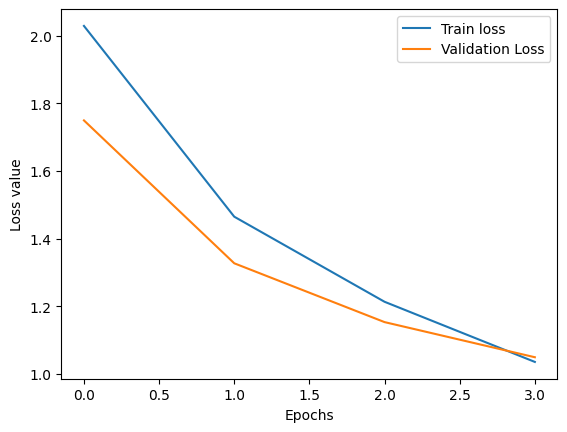

In [10]:
'''
Q8
'''
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

Working on mps
Epoch 1: Train loss: 2.023063152094186, Validation loss 1.62197744846344
Epoch 2: Train loss: 1.5313499571036926, Validation loss 1.4059046506881714
Epoch 3: Train loss: 1.3465863697359521, Validation loss 1.199293613433838
Epoch 4: Train loss: 1.2073037558004631, Validation loss 1.149430751800537
Epoch 5: Train loss: 1.1239264288622832, Validation loss 1.0922821760177612
Epoch 6: Train loss: 1.062900562852297, Validation loss 1.0244656801223755
Accuracy on the test set: 65.6 %


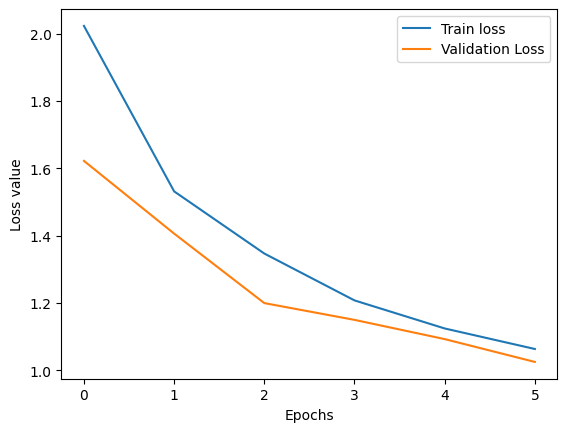

In [17]:
'''
Q9
'''
model = CNN3(0.5)
learning_rate = 0.0302
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

train_loss_list = []
validation_loss_list = []
n_epochs = 6 # with the introductions of the Dropout who avoid overfitting we can add some epochs

for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")


plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

## Main

In [12]:
# Write your code here
print("Hello World!")

'''
DON'T MODIFY THE SEED!
'''
# Set the seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

Hello World!


In [13]:
'''
Q1 - Code
'''
pass

In [14]:
'''
Q2 - Code
'''
    
pass

In [15]:
'''
Q10 -  Code
'''
for seed in range(5,10):
    torch.manual_seed(seed)
    print("Seed equal to ", torch.random.initial_seed())
    # Train the models here


Seed equal to  5
Seed equal to  6
Seed equal to  7
Seed equal to  8
Seed equal to  9
